In [1]:
import xarray as xr
import numpy as np
%pdb
import matplotlib.pyplot as plt
import copy
import pandas as pd
import classification as cl

Automatic pdb calling has been turned ON

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
days_2021 = np.arange(
    np.datetime64('2021-01-01'), np.datetime64('2021-03-01'), np.timedelta64(1, 'D'))
days_2022 = np.arange(
    np.datetime64('2022-01-01'), np.datetime64('2022-03-01'), np.timedelta64(1, 'D'))
days_list = [days_2021, days_2022]

days_hours_2021 = np.arange(
    np.datetime64('2021-01-01'), np.datetime64('2021-03-01'), np.timedelta64(6, 'h'))
days_hours_2022 = np.arange(
    np.datetime64('2022-01-01'), np.datetime64('2022-03-01'), np.timedelta64(6, 'h'))
days_hours_list = [days_hours_2021, days_hours_2022]

In [3]:
pope_df = pd.read_csv(
    'fake_pope_regimes.csv', header=None, 
    index_col=0, names=['time', 'pope_regime'])
pope_df.index = pd.to_datetime(pope_df.index)

In [4]:
lon = 130.925
lat = -12.457

times = np.arange(0, 24, 6)

base_dir = '/g/data/w40/esh563/era5/pressure-levels/reanalysis/'

years = [2021, 2022]

hours = [0, 6, 12, 18]

soundings_ds = [[] for i in range(len(hours))]

for i in range(len(years)):
      
    datasets = []
    for var in ['u', 'v', 't', 'z']:
        
        print('Loading {}, {}'.format(years[i], var))
            
        ds = xr.open_mfdataset(
            [
                base_dir 
                + '{}/{}/{}_era5_oper_pl_{}0101-{}0131.nc'.format(
                    var, years[i], var, years[i], years[i]),
                base_dir 
                + '{}/{}/{}_era5_oper_pl_{}0201-{}0228.nc'.format(
                    var, years[i], var, years[i], years[i])])
        
        ds = ds.sel(
            time=days_hours_list[i], longitude=lon, 
            latitude=lat, method='nearest')
        ds = ds.load()
        
        datasets.append(ds)
    
    [u, v, t, z] = datasets

    for j in range(len(days_list[i])):

        print('Getting {}'.format(days_list[i][j]))
        
        for k in range(len(hours)):
            
            time_jk = days_list[i][j] + np.timedelta64(hours[k], 'h')
            u_t = u.sel(time=time_jk)
            v_t = v.sel(time=time_jk)
            t_t = t.sel(time=time_jk)
            z_t = z.sel(time=time_jk)
            
            z_t = z_t['z'] / 9.80665

            p_t = copy.deepcopy(u_t)
            p_t = p_t.rename({'u':'p'})
            p_t['p'] = p_t['level']
            
            u_t = u_t.rename({'level': 'altitude'})
            v_t = v_t.rename({'level': 'altitude'})
            t_t = t_t.rename({'level': 'altitude'})
            p_t = p_t.rename({'level': 'altitude'})

            u_t = u_t['u'].assign_coords({'altitude': z_t.values})
            v_t = v_t['v'].assign_coords({'altitude': z_t.values})
            t_t = t_t['t'].assign_coords({'altitude': z_t.values})
            p_t = p_t['p'].assign_coords({'altitude': z_t.values})
            
            ds_t = xr.Dataset({
                'u': u_t, 'v': v_t, 
                'p': p_t, 't':t_t})
            
            ds_t = ds_t.sel(altitude=slice(25e3, 0))
            
            new_alts = np.arange(100, 20100, 100)
            ds_t = ds_t.interp(altitude=new_alts)
            
            ds_t['time'] = ds_t['time'] - np.timedelta64(hours[k], 'h')
            
            ds_t['pope_regime'] = pope_df.loc[ds_t['time'].values]
            
            soundings_ds[k].append(ds_t)            

new_ds = []

for i in range(len(hours)):
    ds_i = xr.concat(soundings_ds[i], dim='time')
    ds_i = ds_i.drop('dim_0')
    ds_i = ds_i.squeeze()
    new_ds.append(ds_i)

hours_da = xr.DataArray(hours, name='hour', coords={'hour': hours})

ERA5_soundings = xr.concat(new_ds, dim=hours_da)

Loading 2021, u
Loading 2021, v
Loading 2021, t
Loading 2021, z
Getting 2021-01-01
Getting 2021-01-02
Getting 2021-01-03
Getting 2021-01-04
Getting 2021-01-05
Getting 2021-01-06
Getting 2021-01-07
Getting 2021-01-08
Getting 2021-01-09
Getting 2021-01-10
Getting 2021-01-11
Getting 2021-01-12
Getting 2021-01-13
Getting 2021-01-14
Getting 2021-01-15
Getting 2021-01-16
Getting 2021-01-17
Getting 2021-01-18
Getting 2021-01-19
Getting 2021-01-20
Getting 2021-01-21
Getting 2021-01-22
Getting 2021-01-23
Getting 2021-01-24
Getting 2021-01-25
Getting 2021-01-26
Getting 2021-01-27
Getting 2021-01-28
Getting 2021-01-29
Getting 2021-01-30
Getting 2021-01-31
Getting 2021-02-01
Getting 2021-02-02
Getting 2021-02-03
Getting 2021-02-04
Getting 2021-02-05
Getting 2021-02-06
Getting 2021-02-07
Getting 2021-02-08
Getting 2021-02-09
Getting 2021-02-10
Getting 2021-02-11
Getting 2021-02-12
Getting 2021-02-13
Getting 2021-02-14
Getting 2021-02-15
Getting 2021-02-16
Getting 2021-02-17
Getting 2021-02-18
Getti

In [5]:
R = 287.04
cp = 1005

ERA5_soundings['theta'] = ERA5_soundings['t']*(1e3/ERA5_soundings['p'])**(R/cp)

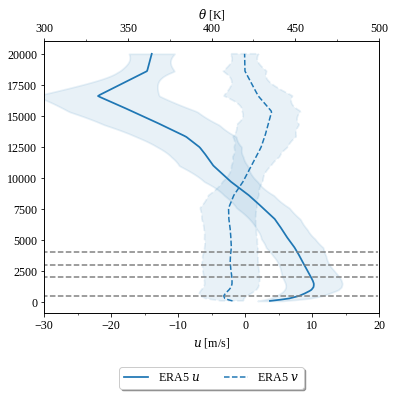

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

cl.init_fonts()

pope_regime = 2

min_speed = 0
max_speed = 0

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [colors[i] for i in [0, 1, 2, 4, 5, 6]]

hours = np.arange(0, 24, 6)
    
ERA5_soundings_pope = ERA5_soundings.where(
    ERA5_soundings['pope_regime']==pope_regime)

u_t = ERA5_soundings_pope['u'].mean(dim=['hour', 'time'])
v_t = ERA5_soundings_pope['v'].mean(dim=['hour', 'time'])
t_t = ERA5_soundings_pope['t'].mean(dim=['hour', 'time'])

u_t_sig = np.sqrt(ERA5_soundings_pope['u'].var(dim=['hour', 'time']))
v_t_sig = np.sqrt(ERA5_soundings_pope['v'].var(dim=['hour', 'time']))
t_t_sig = np.sqrt(ERA5_soundings_pope['t'].var(dim=['hour', 'time']))

# hour = 18

# u_t = ERA5_soundings_pope['u'].sel(hour=hour).mean(dim='time')
# v_t = ERA5_soundings_pope['v'].sel(hour=hour).mean(dim='time')
# t_t = ERA5_soundings_pope['t'].sel(hour=hour).mean(dim='time')

# u_t_sig = np.sqrt(ERA5_soundings_pope['u'].sel(hour=hour).var(dim='time'))
# v_t_sig = np.sqrt(ERA5_soundings_pope['v'].sel(hour=hour).var(dim='time'))

ax.plot(
    u_t, u_t.altitude, color=colors[0], label=r'ERA5 $u$', 
    linewidth=1.75)
ax.fill_betweenx(
    u_t.altitude, u_t-u_t_sig, u_t+u_t_sig, color=colors[0], 
    alpha=0.1, linewidth=1.75)

ax.plot(
    v_t, v_t.altitude, color=colors[0], label=r'ERA5 $v$', 
    linestyle='dashed')
ax.fill_betweenx(
    v_t.altitude, v_t-v_t_sig, v_t+v_t_sig, color=colors[0], 
    alpha=0.1, linewidth=1.75, linestyle='--')

ax.set_xticks(np.arange(-30, 30, 10))
ax.set_xticks(np.arange(-30, 25, 5), minor=True)
ax.set_xlabel(r'$u$ [m/s]')

twin0 = ax.twiny()
twin0.xaxis.set_ticks_position("top")
twin0.xaxis.set_label_position("top")

ax.set_xlim([-30, 20])
twin0.set_xlim([300, 500])
twin0.set_xticks(np.arange(300, 550, 50))
twin0.set_xticks(np.arange(300, 525, 25), minor=True)
twin0.set_xlabel(r'$\theta$ [K]')

twin0.plot(
    t_t, t_t.altitude, linestyle='dashdot', color=colors[0], 
    label=r'ERA5 $\theta$')
twin0.fill_betweenx(
    t_t.altitude, t_t-t_t_sig, t_t+t_t_sig, color=colors[0], 
    alpha=0.1, linewidth=1.75, linestyle='dashdot')

min_speed = min(min(np.concatenate([u_t.values, v_t.values])), min_speed)
max_speed = max(max(np.concatenate([u_t.values, v_t.values])), max_speed)

max_sig = max(np.max(v_t_sig), np.max(u_t_sig))

ax.plot([min_speed-max_sig, max_speed+max_sig], [500, 500], linestyle='dashed', color='grey')
ax.plot([min_speed-max_sig, max_speed+max_sig], [3000, 3000], linestyle='dashed', color='grey')
ax.plot([min_speed-max_sig, max_speed+max_sig], [2000, 2000], linestyle='dashed', color='grey')
ax.plot([min_speed-max_sig, max_speed+max_sig], [4000, 4000], linestyle='dashed', color='grey')

ax.legend(
    loc='lower center', bbox_to_anchor=(.5, -0.30),
    ncol=2, fancybox=True, shadow=True)